<a href="https://colab.research.google.com/github/Saurabhbaghel/ticket-classification-assignment/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUTOMATIC TICKET CLASSIFICATION - CASE STUDY</h1>

#### - Submitted by: Saurabh Baghel & Abhijeet Umbarkar</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# Libraries for data loading and manipulation
import pandas as pd
import numpy as np
import json
import pickle


# Libraries for data visualization and EDA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Libraries for text preprocessing
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")
# from subprocess import check_output
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# Libraries for machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [5]:
## Suppress  the Warnings Messages
import warnings
warnings.filterwarnings('ignore')


## Set limits for displaying rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Task 1 - Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file 
# f = open('./complaints.json')# Write the path to your data file and load it 
f = open('/content/drive/MyDrive/complaints.json')  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
print("Our dataset has",df.shape[0],"customer complaints with",df.shape[1],"features")

Our dataset has 78313 customer complaints with 22 features


In [9]:
## Display column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [11]:
df.isna().sum(0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [12]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Below are some findings based on previous snippets
1. Column names have `_source_` prefixes. We don't want that. We will remove that
2. `score` is only one column with numerical values.
3. The column **_source.complaint_what_happened** hold what is customer complaints, what is the problem he/she is facing while using the services, are there are any frauds, etc
4. There are lot's of columns whose values are missing, however those are not required, hence we will keep those as it is.

## Task 2 - Data Cleaning

We will rename columns in this steps. Also we will take care of other steps as well

In [13]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [14]:
#print the column names
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [15]:
#Assign new column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

Next, we will remove complaints that are blanks.

In [16]:
## Counting number of rows with blank under complaints column
len(df[df['complaint_what_happened'] == ""])

57241

There are total **57,241** complaints which are blanks

In [17]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [18]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)
len(df[df['complaint_what_happened'] == ""])

0

In [19]:
## View the shape of modified dataframe
df.shape

(21072, 22)

## Task 3 - Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [20]:
## View first five rows of complaint column
df['complaint_what_happened'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [21]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    '''This function 
        - makes the given text lowercase
        - removes text in square brackets
        - removes punctuation and 
        - removes words containing numbers.
    :param text: text to be cleaned
    :return: cleaned text
    '''
    
    # Make the text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [22]:
# Apply the above function to complaint column and make a new dataframe containing text-cleaned complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))

# View first five rows of text-cleaned dataframe
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


####  After performing cleaning operations, we do the following:
- Lemmatize the texts
- Use POS tags to get relevant words from the texts. 

In [23]:
#Write your function to Lemmatize the texts
def lemmatizer(text):     
    """
    This function lemmatizes the given input text.
    :param text: given text
    :return: lemmatized text
    """
    
    # Initialize empty list to store lemmas
    sent = []
    
    # Extract lemmas of given text and add to the list 'sent'
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(sent)

In [24]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [25]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than of get the notification on the screen and i be tell by the chase represent

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
#Write your function to extract the POS tags 
import nltk
nltk.download('averaged_perceptron_tagger')
def pos_tag(text):
    # write your code here
    # Create a textblob object
    blob = TextBlob(text)
    
    # extract words with tags 'NN', join them and return
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])


df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [28]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket i come acro

## Task 4 - Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [29]:
# Create list of lengths of pre-processed complaints
doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]
doc_lens[:5]

[192, 102, 74, 446, 192]

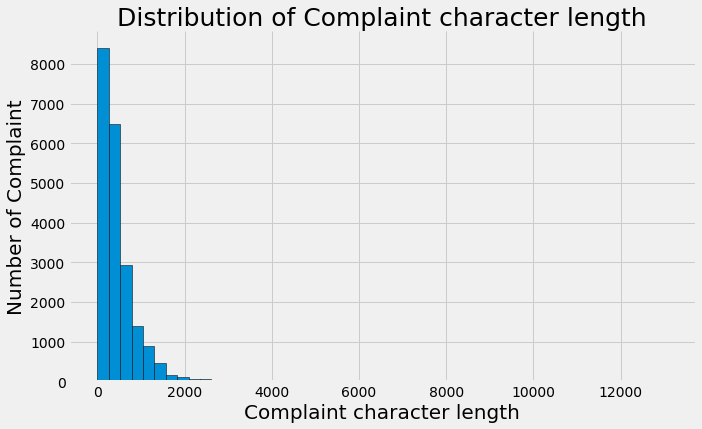

In [30]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
plt.hist(doc_lens, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=25)
plt.ylabel('Number of Complaint', fontsize=20)
plt.xlabel('Complaint character length', fontsize=20)
sns.despine()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

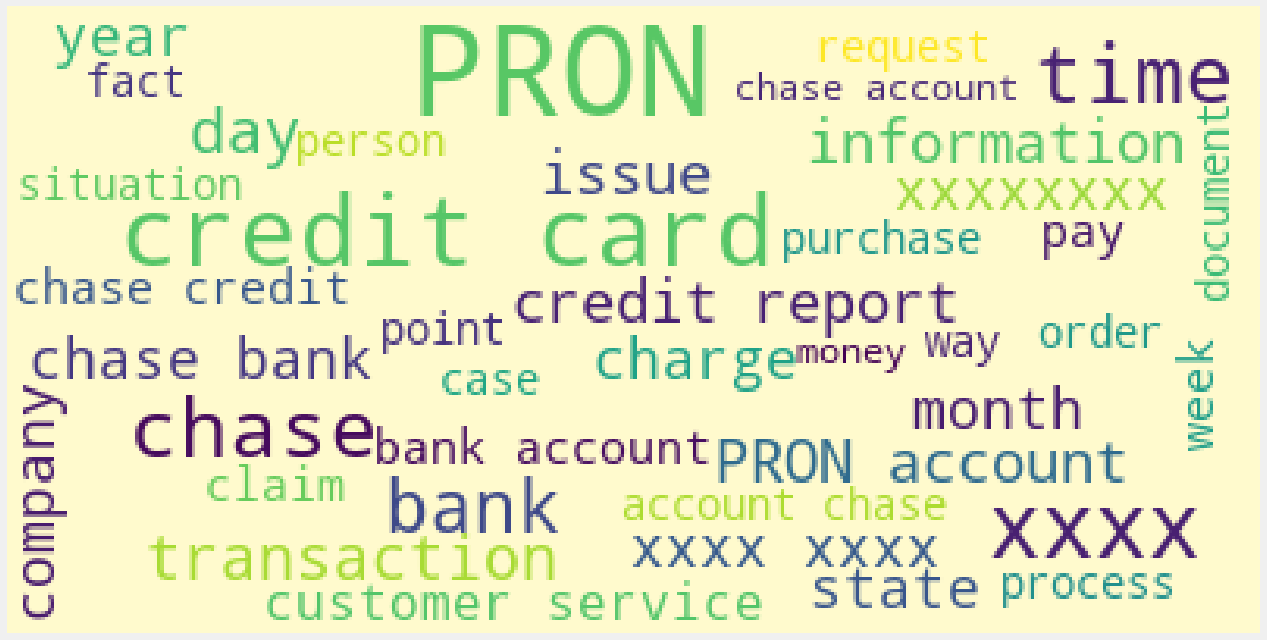

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='lemonchiffon',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_words(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n words(unigrams) among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(unigrams) to find
    :return: list of tuples with two elements each: the word and its frequency
    """
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

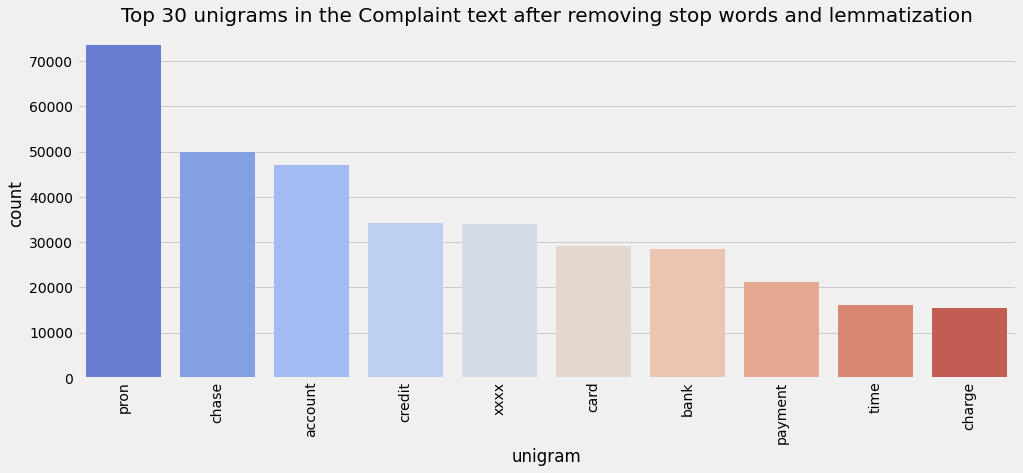

In [34]:
#Print the top 10 words in the unigram frequency
common_words = get_top_n_words(df_clean['complaint_POS_removed'].values.astype('U'), 10)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df2, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [35]:
df2.head(10)

,unigram,count
0,pron,73660
1,chase,50015
2,account,47168
3,credit,34149
4,xxxx,34013
5,card,29071
6,bank,28392
7,payment,21159
8,time,16025
9,charge,15539


In [36]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n bigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top bigrams to find
    :return: list of tuples with two elements each: the bigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

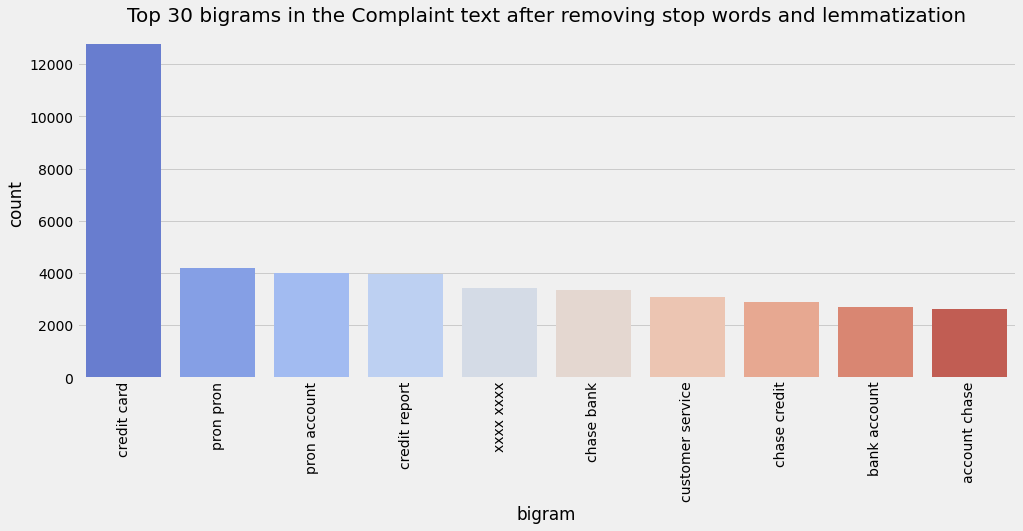

In [37]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_bigram(df_clean['complaint_POS_removed'].values.astype('U'), 10)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df3, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [38]:
df3.head(10)

,bigram,count
0,credit card,12765
1,pron pron,4182
2,pron account,3998
3,credit report,3979
4,xxxx xxxx,3411
5,chase bank,3360
6,customer service,3078
7,chase credit,2889
8,bank account,2690
9,account chase,2628


In [39]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    """
    This function takes a corpus of words (text) and returns the top n trigrams among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top trigrams to find
    :return: list of tuples with two elements each: the trigram and its frequency
    """
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

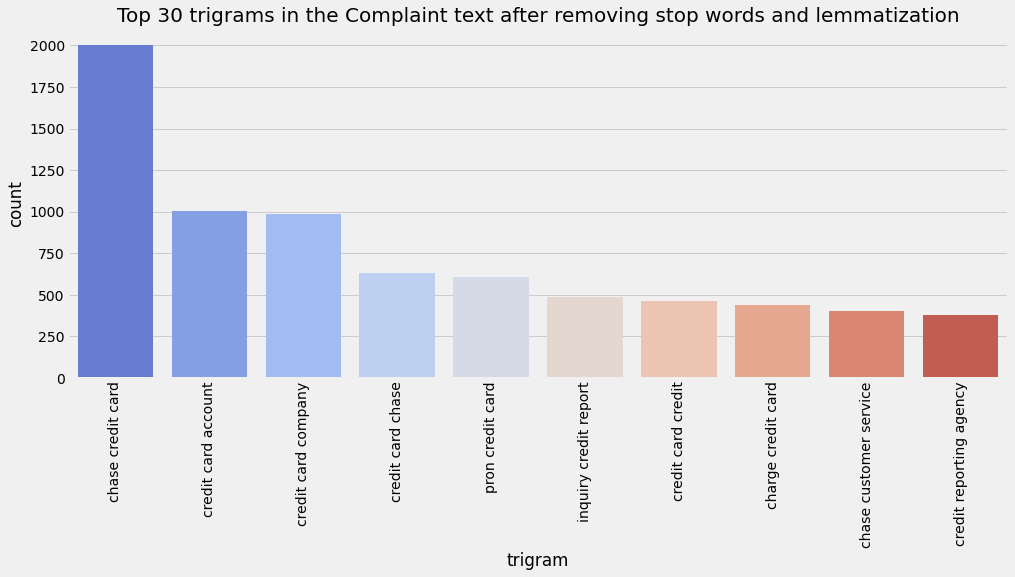

In [40]:
#Print the top 10 words in the trigram frequency
common_words = get_top_n_trigram(df_clean['complaint_POS_removed'].values.astype('U'), 10)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df4, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [41]:
df4.head(10)

,trigram,count
0,chase credit card,2005
1,credit card account,1006
2,credit card company,988
3,credit card chase,633
4,pron credit card,605
5,inquiry credit report,488
6,credit card credit,460
7,charge credit card,436
8,chase customer service,403
9,credit reporting agency,381


### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [42]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [43]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the ch

In [44]:
df_clean['Complaint_clean'].values[1:9]

array(['i card agent upgrade date agent information order account change date  consent recording agent',
       'card report application identity consent service credit identity applicant',
       'try book  ticket i offer ticket card i information offer minute screen decision  bank i chase bank notification screen i chase representative i application state i ask information  offer  credit offer account statement use ticket i account i application representative oblige put application explicit request application chase chase fact credit account name report credit report chase information credit report application error',
       'son check deposit  chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date check number claim number chase',
       'inquiry',
       'jp restrict account debit card tuesday thursday i branch customer service representative account branch fund deposit place employment bank associate

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(
    max_df = 0.95, min_df = 2
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document = vectorizer.fit_transform(df_clean['Complaint_clean'])
DOC_TERM_MATRIX = document.toarray()

In [47]:
print(document)

  (0, 3241)	0.16693761170395305
  (0, 140)	0.2514231856815229
  (0, 6793)	0.19576770659197176
  (0, 55)	0.07753225871190189
  (0, 1118)	0.06818934780206698
  (0, 1521)	0.17376478069410292
  (0, 3567)	0.1242433658307796
  (0, 5894)	0.20533146186523749
  (0, 458)	0.176602839159429
  (0, 4423)	0.1243047162425895
  (0, 4116)	0.16419705176532257
  (0, 6468)	0.15313816010434048
  (0, 7236)	0.24689496867440855
  (0, 1838)	0.538280669543672
  (0, 412)	0.1727732221999645
  (0, 6137)	0.13120882199714248
  (0, 975)	0.31076834469332826
  (0, 573)	0.17627214627436866
  (0, 6506)	0.27694335326909364
  (0, 4512)	0.14789803853384675
  (0, 4440)	0.22604985406128658
  (1, 5565)	0.31980120332519524
  (1, 1489)	0.27417428013251594
  (1, 1091)	0.20747025061583324
  (1, 4734)	0.1834466008440529
  :	:
  (21070, 1091)	0.08197512853752795
  (21070, 969)	0.2796663881390536
  (21070, 1118)	0.11646060608208073
  (21071, 6040)	0.23211372442395842
  (21071, 3643)	0.20880945110920834
  (21071, 2226)	0.17771547952802

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [48]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [49]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40) #write your code here

In [50]:
nmf_model.fit(document)
len(vectorizer.get_feature_names())

7547

In [51]:
vectorizer.get_feature_names()[1]

'aarp'

In [52]:
#Print the Top15 words for each of the topics

features=vectorizer.get_feature_names()
top_word_arr = list()

for row_num in range(nmf_model.components_.shape[0]):
  row2 = nmf_model.components_[row_num]
  li = list()
  for num in range(15):
    for i in range(len(row2)):
      if row2[i] == row2.max():
        li.append(features[i])
        row2 = np.delete(row2,i,0)
        break
      else:
        continue
  top_word_arr.append(li)
  

topics = [f'Topic {num}' for num in range(1,num_topics+1)]
top_word_df = pd.DataFrame(dict(zip(topics,top_word_arr)),index = range(1,16))
top_word_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
1,account,credit,payment,charge,loan
2,bang,card,balance,card,mortgag
3,cheater,repo,interchange,charter,home
4,mon,inquirie,mont,feature,chase
5,function,chas,startup,disposition,modication
6,charter,account,fedex,tranaction,prompt
7,deplete,schooling,patron,menus,xxx
8,brag,comp,amount,pump,let
9,dating,like,daughterinlaw,ck,tie
10,notion,infomation,bike,fragmentation,doctrine


In [53]:
word='card'
for topic,words in zip(range(5),top_word_arr):
  if word in words:
    print(topic)

1
3


In [54]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4


In [55]:
#Assign the best topic to each of the cmplaints in Topic Column
def get_topic(x):
  '''
  - This function assigns the topic (0,1,2,3 or 4) 
  '''
  # print(x)
  for word in x.split():
    # print(word)
    for topic,words in zip(range(5),top_word_arr):
      if word in words:
        return topic

        # return topic
df_clean['Topic']=df_clean['Complaint_clean'].apply(lambda x: get_topic(x))
 #write your code to assign topics to each rows.

In [56]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,4.0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date xxxxxxxx consent recording agent,i card agent upgrade date agent information order account change date consent recording agent,1.0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1.0
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i 

In [57]:
#Print the first 5 Complaint for each of the Topics
df_clean2=df_clean.groupby('Topic').head(5)
df_clean2.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
24,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0.0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursday i go into a branch after be advise by a customer service representative that -PRON- account would actually be close i go into the branch to see how i can remove the fund that be in there currently in as well as if -PRON- direct deposit from -PRON- place of employment would be return the bank associate and the customer service representative assure -PRON- that the fund would post but -PRON- may take an additional business day that saturday i attempt to go inside of a branch yet again to retrieve -PRON- fund that actually do post on friday upon look at -PRON- account i realize that the fund have be reverse and no longer be present on -PRON- current statement -PRON- have be call and i be tell that -PRON- may take two business day state tuesday xxxxxxxx would be the date that -PRON- fund would be available to withdraw from a bank teller only now chase be inform -PRON- that i will be mail a check into the three business day to recover the fund that be owe to -PRON- and leave in -PRON- account currently unfortunately this have put -PRON- in an additional financial bind do two fee from late rent late car payment etc i be not be a short or give write notice that these thing will actually occur so that i have peace of mind in fact chase have handle -PRON- situation grossly i even have a bank teller inform -PRON- that -PRON- account look suspicious after give -PRON- a suspicious look -PRON- although i know that chase

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [58]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account Services', 1:'Credit Card or Prepaid Card', 2:'Theft/DIspute Reporting', 3:'Mortgage/Loan', 4:'Others'   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)


    Bank Account services
    Credit card or prepaid card
    Theft/Dispute Reporting
    Mortgage/Loan
    Others


In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services':0,'Credit Card or Prepaid Card':1,'Theft/Dispute Reporting':2, 'Mortgage/Loan':3 , 'Others':4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean.shape

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [ ]:
training_data.shape

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
countvect = CountVectorizer()
counts = countvect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(counts)

In [16]:
train_test_split?

In [ ]:
#Create train-test-split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,training_data['Topic'], test_size = 0.2,random_state = 42) 

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics
logreg = LogisticRegression().predict(X_train,y_train)

tree = DecisionTreeClassifier(
    max_depth = 13, min_samples_split = 100,
    random_state = 42
).predict(X_train,y_train)

randomforest = RandomForestClassifier(
    n_estimators = 200, max_depth = 10,
    min_samples_split = 100
).predict(X_train,y_train)

mnb = MultinomialNB().predict(X_train,y_train)

svc = SVC()

In [21]:
y_pred_logreg = logreg.predict_proba(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_rf = randomforest.predict(X_test)
y_pred_mnb = mnb.predict(X_test)

Object `sklearn.svm.LinearSVC` not found.


In [24]:
def evaluate(y_pred,y):
  confusion_matrix()
